The miner reward scheme for producing blocks for eth1's Proof-of-Work blockchain is straightforward — a fixed block reward (2 ETH per block since the St. Petersburg hard fork in February 2019) plus fees paid to the miner for transaction inclusion. Things become somewhat more complicated in the proof-of-stake protocol used by eth2 however.

Rather than a single large reward paid to the miner of a block, under proof of stake, all active validators are rewarded for their participation in the protocol through a series of micro-rewards. Incorrect participation (or failure to participate) is penalised through equivalent micro-penalties. Two other scenarios introduce additional penalties to ensure the protocol functions as intended — (1) inactivity leak applied when less than ⅔ of the validators participate for an extended period and (2) slashing for "provably malicious" actions carried out by validators.

This article will explain these concepts with some illustrations to help validators to understand what they are rewarded and penalised for, and therefore how they can maximise their rewards and avoid penalties.

# Attestation Components

Rewards for eth2 validators are largely determined by their performance submitting *attestations*. Every validator is required to submit a single attestation each *epoch* (an epoch is 6.4 minutes long, and is made up of 32 *slots* of 12 seconds each).

An attestation can be thought of as being a vote on the current state of the chain, made up of 3 components:
1. The hash of the block at the current *head* of the chain as determined by the LMD GHOST fork choice rule. This is what the validator has determined is the current "latest" block;
2. The hash of the *source* block, used for the CasperFFG finality process;
3. The hash of the *target* block, used for the CasperFFG finality process.

To understand what all of these things mean in detail, I'd recommend reading the [Gasper](https://arxiv.org/pdf/2003.03052.pdf) paper, which formally defines the eth2 consensus protocol as a synthesis of the LMD GHOST fork choice rule and the CasperFFG finality overlay. However, if you don't want to get too deep into the detail, you can just think of the three components as a representation of the current state of the blockchain, on which the validator is voting. If the validator votes correctly (in line with the rest of the network) they will be rewarded for each of these three votes. If they vote incorrectly (at odds with the network) they will be penalised.

# Block Proposal and Inclusion Delay

Blocks themselves, with the exception of the genesis block, are composed of collections of attestations. Each block is produced (and *proposed*) by a validator, nominated at random by the protocol, who collects attestations from all the other validators through a process of *aggregation*.

In addition to the 3 attestation reward components above, there is a fourth reward paid, which for each attestation is split between the attesting validator and the block proposer. It is the *inclusion delay* reward. This reward scales inversely to the number of slots between the attestation being made, and the attestation being included in a block. The ratio of rewards paid to the attester and the block proposer is called the `PROPOSER_REWARD_QUOTIENT`. In the eth2 spec this is set to a value of 8 — i.e. ⅞ of the reward goes to the attesting validator and ⅛ goes to the block producer.

Since all validators have an equal chance of being the block proposer, over a long timescale a given validator will receive ⅞ of their inclusion delay rewards for their attestations, and ⅛ from block proposal. Even as more validators join the network and the number of block proposal opportunities per validator goes down, the blocks themselves become more valuable as they contain more attestations, so the reward ratio between attestation and block proposal remains constant.

# Base Reward

All 4 rewards described above (*source reward*, *target reward*, *head reward* and *inclusion delay reward*) are calculated on a per-validator basis using a quantity called the `base_reward`. This base reward for a given validator, measured in Gwei, or equivalently nanoeth, varies in proportion with that validator's *effective balance* and with the inverse square root of the sum of all active validators' *effective balance*. The `base_reward` $b_i$ for a validator $i$ with effective balance $e_i$ is given by the formula:

$$ b_i = \frac{F}{B\sqrt{E}}e_i $$


where $F$ is the `BASE_REWARD_FACTOR` (fixed at 64 in the eth2 spec) and is essentially the constant that determines the overall issuance of the eth2 protocol. $B$ is the `BASE_REWARDS_PER_EPOCH` constant and is the count of all the separate things a validator can be rewarded for (as described above, there are 4 separate rewards), and $E$ is the sum of the effective balance of all active validators, i.e. $$ E = \sum_{j\in A}e_j $$ where $A$ is the set of active validator indices.


# Issuance and Return Under Ideal Conditions

Bearing in mind that the maximum *effective balance* for a validator is 32 ETH, we now know enough to calculate what the maximum total issuance, and maximum validator return will be. This will only occur under ideal conditions (no missed blocks, no incorrect head, source or target votes, and an inclusion delay of $1$ for all validators).

In this scenario, all validator effective balances $e_i$ are 32 ETH, and all validators receive the maximum 4 rewards per epoch (i.e. $4b_i$), cancelling out `BASE_REWARDS_PER_EPOCH` $B$ from the denominator above. So the maximum per-epoch reward (averaged over many epochs) for each validator $r_\max$ is given by:

$$ \begin{align} r_{\max}&=\frac{64}{\sqrt{E}}\times 32 \\ &= \frac{2048}{\sqrt{E}} \end{align} $$

Note that we describe the maximum *average* per epoch reward, because ⅛ of the inclusion delay reward is actually given to the block proposer. Since each block proposer is chosen at random from all validators, the inclusion dealy reward is allocated in a "lumpy" fashion, but on average for perfect validation, each validator will receive $b_i$ per epoch for this reward.

To turn this into an annualised maximum reward rate $R_\max$ we just multiply by the number of epochs (384 seconds) per year (solar year length is 365.2422 days $\simeq$ 31556926 seconds) i.e. 82179.5 epochs per year. Dividing by the 32 ETH initial stake size gives us the familiar staking reward curve shown on the [eth2 launchpad](https://launchpad.ethereum.org/) and elsewhere:

22.969868544617995
5.259488


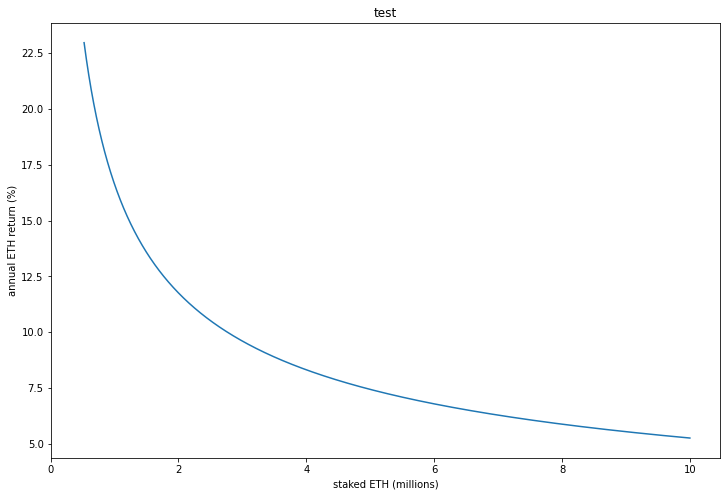

In [1]:
import matplotlib.pyplot as plt
import math

staked = [s for s in range(524288,10000000,1000)]
numerator = 82179.5 * 2048
Rmax = [100 * numerator / math.sqrt(s * 10**9) / 32 for s in staked]

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot([s / 10**6 for s in staked], Rmax)
ax.set_xlim(xmin=0)
ax.set_xlabel('staked ETH (millions)')
ax.set_ylabel('annual ETH return (%)')

print(100 * numerator / math.sqrt(524288 * 10**9) / 32)
print(100 * numerator / math.sqrt(10000000 * 10**9) / 32)

# Penalties

# Formula

# Inactivity Leak

# Slashing

# Conclusions
- Under normal circumstances, validators receive 75% of the available reward just for attesting correclty;
- a further (up to) 21.875% of the available rewards are for prompt inclusion of attestations in the blockchain;
- the final (up to) 3.125% of rewards are given for block proposal.

However, although the above holds over the long term and under "steady state" conditions, the assignment of block proposer for any given slot is random, and as a result block proposal rewards will be uneven and lumpy.

In [4]:

import eth2spec.phase0.spec as eth2
import math
#import pandas as pd

In [5]:
genesis_min_stake = int(eth2.MIN_GENESIS_ACTIVE_VALIDATOR_COUNT * eth2.MAX_EFFECTIVE_BALANCE) / 10**9

staked = [x for x in range(genesis_min_stake, 100 * 10**6, 32)]

524288


In [3]:
print(eth2.MIN_GENESIS_ACTIVE_VALIDATOR_COUNT)

16384


Let's look at how `base_reward` varies according to the total amount of ether staked. Here we will assume that all validators have the maximum effective balance of 32 ETH, and consider stake amounts from the minimum of 16384 validators, up to the case where all the ether in existence is staked (according to [TurboGeth](http://mandrigin.ru/eth-supply.html) at block 11360164 the ether supply was 115,203,644, rounded down to integer ETH).

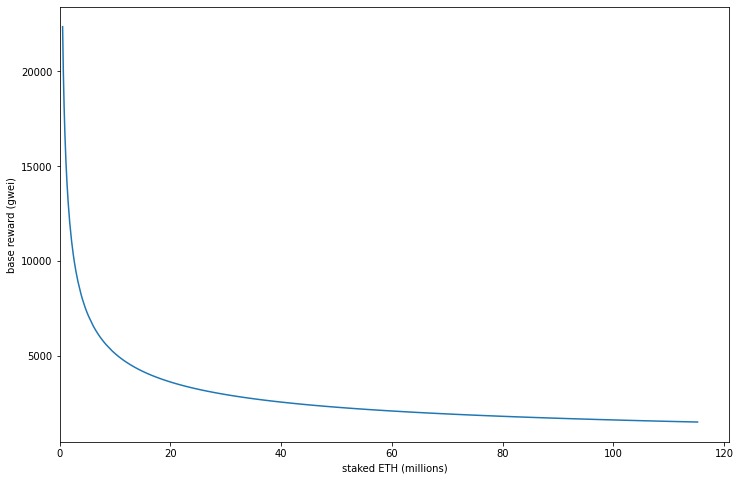

In [19]:
# calculate base reward
min_validators = eth2.MIN_GENESIS_ACTIVE_VALIDATOR_COUNT
ether_supply = 115203644
max_validators = ether_supply // 32
R = eth2.BASE_REWARD_FACTOR // eth2.BASE_REWARDS_PER_EPOCH
stake = [s * 32 for s in range(min_validators, max_validators, 100)]
base_reward = [R * 32 * 10**9 // int(math.sqrt(s * 10**9)) for s in stake]

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot([s / 10**6 for s in stake], base_reward)
ax.set_xlim(xmin=0)
ax.set_xlabel('staked ETH (millions)')
ax.set_ylabel('base reward (gwei)');

The `BASE_REWARDS_PER_EPOCH` constant referenced in the cell above reflects how many multiples of `base_reward` it is possible for a correctly-attesting validator to receive each epoch. Its value of 4 reflects these components:

1. correct attestation to the 